### Initialization cell: run once on notebook start up

In [144]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Find the index from xvals of the value which is closest to xval.  If more than one exact match, returns the lowest index
# xvals should be spaced less than 66e6 apart
def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

# Find the x value corresponding to the max y value from the sets xvals, yvals in the range from xmin to xmax
def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

In [147]:
###Define Inputs
#!!input document must be delineated with two collumns of (x,y) points!!
fouriersignal = np.loadtxt("../../calibration/cal 200325-02 2 amp.txt",float)
hires = 10 #high resolution at low frequencies, set to at least 2;
          #gives a factor of #hires finer frequency sampling, but with a factor of #hires smaller frequency window
hiresoff = 0 #start at frequency hiresoff/T/hires

time = fouriersignal[0:len(fouriersignal)//3*2,0]
signal = fouriersignal[0:len(fouriersignal)//3*2,-1]
T = time[-1] - time[0] #total integration period
N = len(time) #number of points
FFTs = np.zeros([3,N//2]) #Fourier frequencies, amplitudes, and phases
FFTshr = np.zeros([3,N//2]) #high res

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
for f in range(0,N//2): #iterate over frequencies
    A = 0
    Ahr = 0
    for d in range(N): #iterate over data points
        A += signal[d] * np.exp(-1j*2*np.pi*d*f/N) #integrate at frequencies f/N, A = a +ib for the fourier expansion f(t) = a*cos(wt)+bsin(wt)
        Ahr += signal[d] * np.exp(-1j*2*np.pi*d*(f+hiresoff)/N/hires)
    
    FFTs[0][f] = f/T #frequency
    FFTs[1][f] = la.norm(A)/N*2 #amplitude, factor of 2 to account for symmetry of DFT
    FFTs[2][f] = np.arctan2(np.imag(A),np.real(A)) #phase
    
    FFTshr[0][f] = (f+hiresoff)/T/hires #hires frequency
    FFTshr[1][f] = la.norm(Ahr)/N/hires*2 #hires amplitude
    FFTshr[2][f] = np.arctan2(np.imag(Ahr),np.real(Ahr)) #hires phase

#Inverse Fourier transform
invFT = np.zeros(N,complex)
invFThr = np.zeros(N,complex)

for d in range(N): #iterate over data points
    for f in range(N//2): #iterate over frequencies
        invFT[d] += FFTs[1][f] * np.exp(2j*np.pi*d/N*f+1j*FFTs[2][f])
        invFThr[d] += FFTshr[1][f] * np.exp(2j*np.pi*d/N*(f+hiresoff)/hires+1j*FFTshr[2][f])
#take real part and add the DC offset back
ReinvFT = np.real(invFT) + signal[0] - np.real(invFT[0])
ReinvFThr = np.real(invFThr) + signal[0] - np.real(invFThr[0])

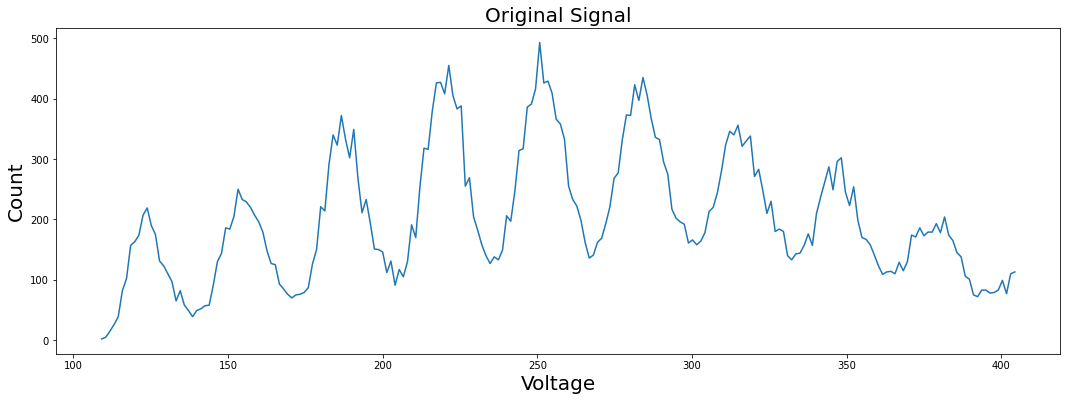

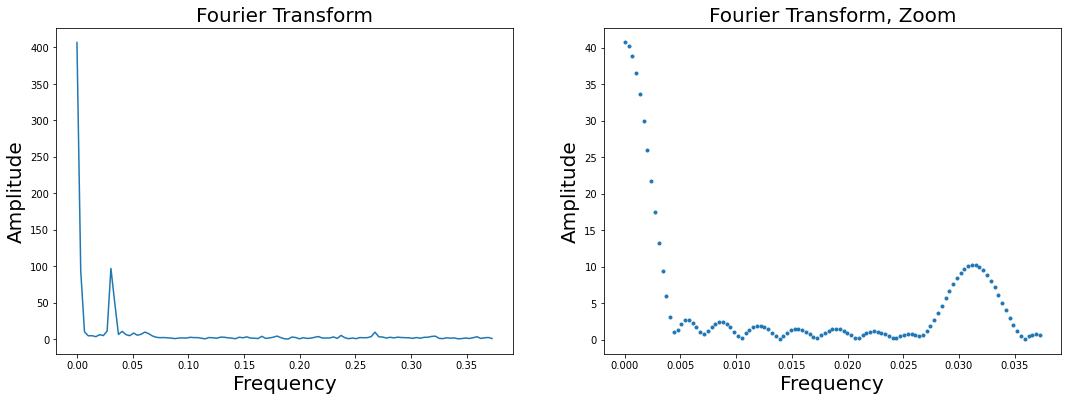

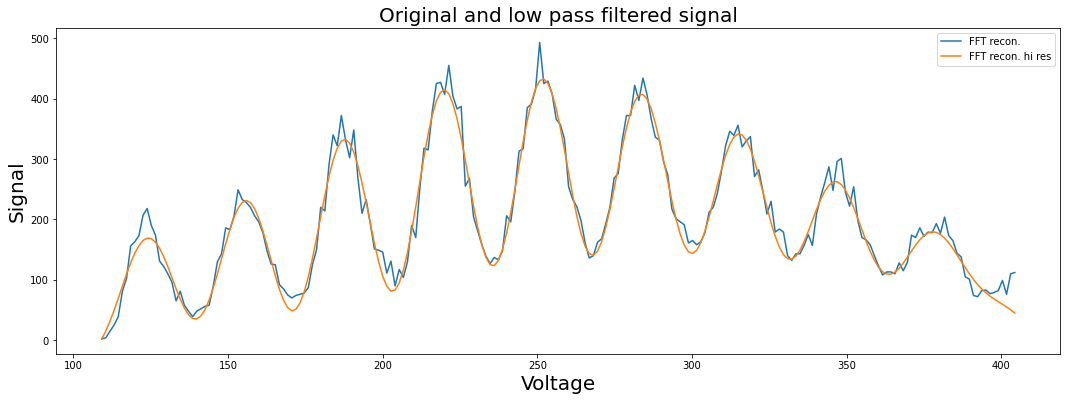

In [148]:
#make plots
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(time,signal)
plt.title("Original Signal", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(FFTs[0],FFTs[1],"-")
ax[0].set_title("Fourier Transform", size=20)
ax[0].set_xlabel("Frequency", size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(FFTshr[0],FFTshr[1],".")
ax[1].set_title("Fourier Transform, Zoom", size=20)
ax[1].set_xlabel("Frequency", size=20)
ax[1].set_ylabel("Amplitude", size=20)
plt.show()

plt.plot(time,ReinvFT,label="FFT recon.")
plt.plot(time,ReinvFThr,label="FFT recon. hi res")
plt.legend()
plt.title("Original and low pass filtered signal", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Signal", size=20)
plt.show()

## There are two main, expected effects present: The highest frequency components have been removed, smoothing out the sharp peaks, and the exact maxima in the frequency spectrum are more clear.

## The simplest modification to make is a highpass or highpass filter. As the lowpass cutoff decreases, the graph becomes more smooth, but with a similar amplitude. Conversely, the highpass filter preserves many of the detailed features, but drastically reduces the RMS.

In [159]:
#peak finder
max(FFTshr[1,1:N//2])
max_y = max(FFTshr[1,N//4:N//2])  # Find the maximum y value
max_x = FFTshr[0,np.where(FFTshr==max_y)[1][0]]  # Find the x value corresponding to the maximum y value
print("maxima found in the given range at x=" + str(max_x)+", y="+ str(max_y))
print(f'{1/max_x:.3f}')
#print(1/(max_x+0.00011))

print(findmax(FFTshr[0],FFTshr[1],0.02,0.04))

maxima found in the given range at x=0.031168056807171357, y=10.237875575865766
32.084
(0.031168056807171357, 10.237875575865766)


In [160]:
#this is a test cell
fourco_2amp_front = textloader('../../Raw Data/4fold coincidence 60 min 0.1 trig 1and2 frontbar')


print(fourco_2amp_front[1])
max_y = max(fourco_2amp_front[1])
print(max_y)
print(np.where(fourco_2amp_front[1]==119))

print(FFTshr[0])
print(findenum(FFTshr[0],0.04))

[ 23.   8.   1.   0.   0.   0.   0.   0.   0.   0.   3.   4.   7.   4.
   7.   9.  12.  21.  18.  18.  20.  22.  37.  26.  24.  31.  29.  34.
  24.  24.  21.  20.  19.  12. 119.  30.   0.]
119.0
(array([34], dtype=int64),)
[0.         0.00033878 0.00067757 0.00101635 0.00135513 0.00169392
 0.0020327  0.00237148 0.00271027 0.00304905 0.00338783 0.00372662
 0.0040654  0.00440418 0.00474297 0.00508175 0.00542053 0.00575931
 0.0060981  0.00643688 0.00677566 0.00711445 0.00745323 0.00779201
 0.0081308  0.00846958 0.00880836 0.00914715 0.00948593 0.00982471
 0.0101635  0.01050228 0.01084106 0.01117985 0.01151863 0.01185741
 0.0121962  0.01253498 0.01287376 0.01321255 0.01355133 0.01389011
 0.0142289  0.01456768 0.01490646 0.01524525 0.01558403 0.01592281
 0.01626159 0.01660038 0.01693916 0.01727794 0.01761673 0.01795551
 0.01829429 0.01863308 0.01897186 0.01931064 0.01964943 0.01998821
 0.02032699 0.02066578 0.02100456 0.02134334 0.02168213 0.02202091
 0.02235969 0.02269848 0.02303726 0.0233